In [5]:
# 라이브러리 import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import multivariate_normal

### **00. 트레이닝 셋 생성**

In [6]:
# 데이터 셋({x_n, y_n, type_n}) 만드는 함수(create_dataset) 선언하기
# 개수가 N = N1+N2 이고 중심 좌표가 Mu이고 Variance를 가지고 있는 데이터 셋

def create_dataset(variance):
    # 파라미터 설정하기
    N1 = 20 # t=+1인 데이터 개수
    Mu1 = [15,10] # t=+1인 데이터 중심 (x,y) 좌표
    
    N2 = 30 # t=-1인 데이터 개수
    Mu2 = [0,0] # t=-1인 데이터 중심 (x,y) 좌표

    # 공분산 행렬 C = [[Var(X),Cov(X,Y)], [Cov(Y,X),Var(Y)]
    # Var(X): X축 분산, Var(Y): Y축 분산
    # Cov(X,Y) = 0, Cov(Y,X) = 0인 공분산. 두 변수 X, Y는 서로 독립적. 
    # 공분산이 0이고 X축, Y축 분산이 같음
    cov1 = np.array([[variance,0],
                     [0,variance]])
    cov2 = np.array([[variance,0],
                     [0,variance]])

    # t=+1인 데이터 생성
    df1 = pd.DataFrame(multivariate_normal(Mu1,cov1,N1),columns=['x','y'])
    df1['t'] = 1
    # t=-1인 데이터 생성
    df2 = pd.DataFrame(multivariate_normal(Mu2,cov2,N2),columns=['x','y'])
    df2['t'] = -1 
    
    # 생성된 데이터 합치기
    df = pd.concat([df1,df2],ignore_index=True)

    # df에 index를 랜덤으로 섞기
    df = df.reindex(np.random.permutation(df.index))
    
    # df에 index를 처음부터 다시 라벨링하기 
    # drop = True는 새로운 index를 추가로 만들지 않게 하기 위해서
    df = df.reset_index(drop=True)
    
    return df


In [7]:
# 트레인 셋 만들어 보기
Variance = 50
training_set = create_dataset(Variance)

training_set

,x,y,t
0,4.555766,-7.401566,-1
1,13.799142,7.001702,1
2,1.966217,-1.673186,-1
3,15.618304,13.498822,1
4,-4.346371,-2.631364,-1
5,8.544972,-7.272224,-1
6,-2.523541,-1.396861,-1
7,11.248985,17.801970,1
8,7.467792,14.019085,1
9,-6.316997,-7.156733,-1


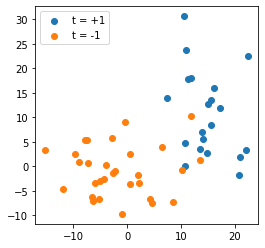

In [8]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(training_set[training_set["t"]==1].x, training_set[training_set["t"]==1].y, label="t = +1")
ax.scatter(training_set[training_set["t"]==-1].x,training_set[training_set["t"]==-1].y, label="t = -1")
ax.legend()
fig.show()

### **01. 확률적 기울기 하강법을 사용한 분류** 

$\bf{w} = \begin{pmatrix} w_0 \\\\ w_1 \\\\ w_2 \end{pmatrix}, \, \phi_n = \begin{pmatrix} c \\\\ x_n \\\\ y_n \end{pmatrix}, \ (c = \frac{1}{2N} \sum_{n=1}^{N} (x_n + y_n))$

$\mathbf{w}_{new} = \mathbf{w}_{old} + t_n \mathbf{\phi}_n \; \; \; (f(x, y) \times t = \mathbf{w}^T {\phi} \times t_n < 0: incorrect)$


In [9]:
def fit_perceptron(training_set, iteration_num, bias=None):
    def calc_stochastic_gradient_descent_w(w):
        # 확률적 기울기 하강
        for _, data in training_set.iterrows():
            x, y, t = data.x, data.y, data.t
            phi = np.array([c, x, y]).reshape(-1, 1)
            if np.dot(w.T, phi) * t <= 0:
                w = w + t * phi  # w_new = w_old + t_n * phi_n
        return w

    def calc_error_rate():
        # 잘못 분류된 데이터 비율(%) 계산하기
        # err_num: 잘못된 데이터 개수
        err_num = 0
        for _, data in training_set.iterrows():
            x, y, t = data.x, data.y, data.t
            phi = np.array([c, x, y]).reshape(-1, 1)
            if np.dot(w.T, phi) * t <= 0:
                err_num += 1
        err_rate = err_num / len(training_set) * 100

        return err_rate
    def calc_error():
        # 잘못 분류된 데이터 비율(%) 계산하기
        # err_num: 잘못된 데이터 개수
        err = 0
        for _, data in training_set.iterrows():
            x, y, t = data.x, data.y, data.t
            phi = np.array([c, x, y]).reshape(-1, 1)
            if np.dot(w.T, phi) * t <= 0:
                err_vector = np.dot(w.T, phi) * t * -1
                err += err_vector.flatten()[0]
        return err

    # c는 bias항
    c = 0
    if bias is None:
        c = 0.5 * (training_set.x.mean() + training_set.y.mean())
    else:
        c = bias

    # w 초기값 설정하기
    w = np.array([0, 0, 0]).reshape(-1, 1)

    # parameter와 error rate를 기록하기 위한 DataFrame 선언
    w_hist = pd.DataFrame([w.flatten()], columns=["w0", "w1", "w2"])
    err_rate_hist = pd.DataFrame([], columns=["err_rate"])
    err_hist = pd.DataFrame([], columns=["err"])

    for i in range(iteration_num):
        w = calc_stochastic_gradient_descent_w(w)
        w_hist = w_hist.append(
            pd.Series(w.flatten(), index=["w0", "w1", "w2"]), ignore_index=True
        )

        err_rate = calc_error_rate()
        err_rate_hist = err_rate_hist.append(
            pd.Series(err_rate, index=["err_rate"]), ignore_index=True
        )

        err = calc_error()
        err_hist = err_hist.append(
            pd.Series(err, index=["err"]), ignore_index=True
        )
    result = {"w": w, "err_rate": err_rate, "bias": c}

    return result, w_hist, err_rate_hist, err_hist


### **02. 결과 시각화** 

In [10]:
# 트레이닝 셋 및 직선 시각화
def plot_data_graph_with_line(training_set, parameters, data_graph): 
    w = parameters["w"]
    bias = parameters["bias"]
    err_rate = parameters["err_rate"]
    
    # t가 1인 데이터셋
    training_set1 = training_set[training_set['t']==1]
    # t가 -1인 데이터셋
    training_set2 = training_set[training_set['t']==-1]

    # plot에서 x,y좌표 최소값 최대값 정하기
    ymin, ymax = training_set.y.min()-5, training_set.y.max()+10
    xmin, xmax = training_set.x.min()-5, training_set.x.max()+10    
    
    data_graph.set_ylim([ymin, ymax])
    data_graph.set_xlim([xmin, xmax])

    # 트레인셋 데이터 그리기
    data_graph.scatter(training_set1.x, training_set1.y, marker='o')
    data_graph.scatter(training_set2.x, training_set2.y, marker='x')

    # 직선 시각화
    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * w[1] / w[2] - bias * w[0] / w[2]
    label = "ERR %.2f%%" % err_rate
    data_graph.plot(linex,liney,label=label,color='red')
    data_graph.legend(loc=1) # loc = 1 : 우측 상단에 범례 표시

# 파라미터 변화 시각화
def plot_w_history(paramhist,param_graph):
    param_graph.set_ylim([-100,100])
    paramhist.plot(ax=param_graph)
    param_graph.legend(loc=1)
# 파라미터 변화 시각화
def plot_error_rate_history(err_rate_hist,err_rate_graph):
    err_rate_graph.set_ylim([-5,50])
    err_rate_hist.plot(ax=err_rate_graph)

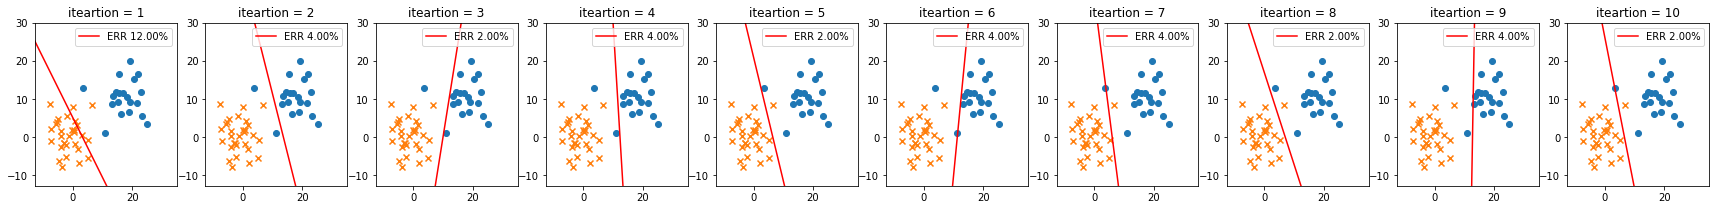

In [11]:
# 이터레이션에 따른 결과 직선 계수(w0, w1, w2)의 변화 시각화
np.random.seed(0)

# 파라미터
max_num_of_iteration = 30
variance = 20

training_set = create_dataset(variance)

fig, axs = plt.subplots(1, 10, figsize=(30,3))

for itr in range(10): 
        result, w_hist, err_hist, _ = fit_perceptron(training_set, itr+1)
        plot_data_graph_with_line(training_set, result, axs[itr])
        axs[itr].set_title("iteartion = %d" % (itr+1))
fig.show()

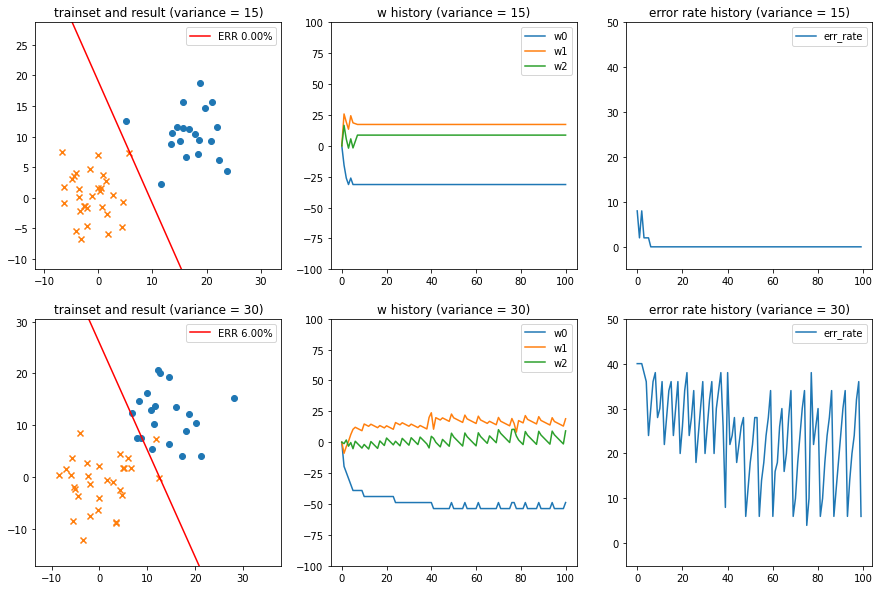

In [12]:
# 서로 다른 variance값을 가진 트레인 셋에서의 결과를 시각화하여 비교하기
np.random.seed(0)

Variances = [15,30] # 분산 정도가 다른 두 데이터를 정의하기 위한 분산 리스트
iteration_num = 100
fig, axs = plt.subplots(2, 3, figsize=(15,10)) 
for c, variance in enumerate(Variances):
    axs[c][0].set_title("trainset and result (variance = %d)" % variance)
    axs[c][1].set_title("w history (variance = %d)" % variance)
    axs[c][2].set_title("error rate history (variance = %d)" % variance)

    training_set = create_dataset(variance)
    result, w_hist, err_rate_hist, _ = fit_perceptron(training_set, iteration_num)

    plot_data_graph_with_line(training_set, result,axs[c][0])
    plot_w_history(w_hist,axs[c][1])
    plot_error_rate_history(err_rate_hist,axs[c][2])
fig.show()

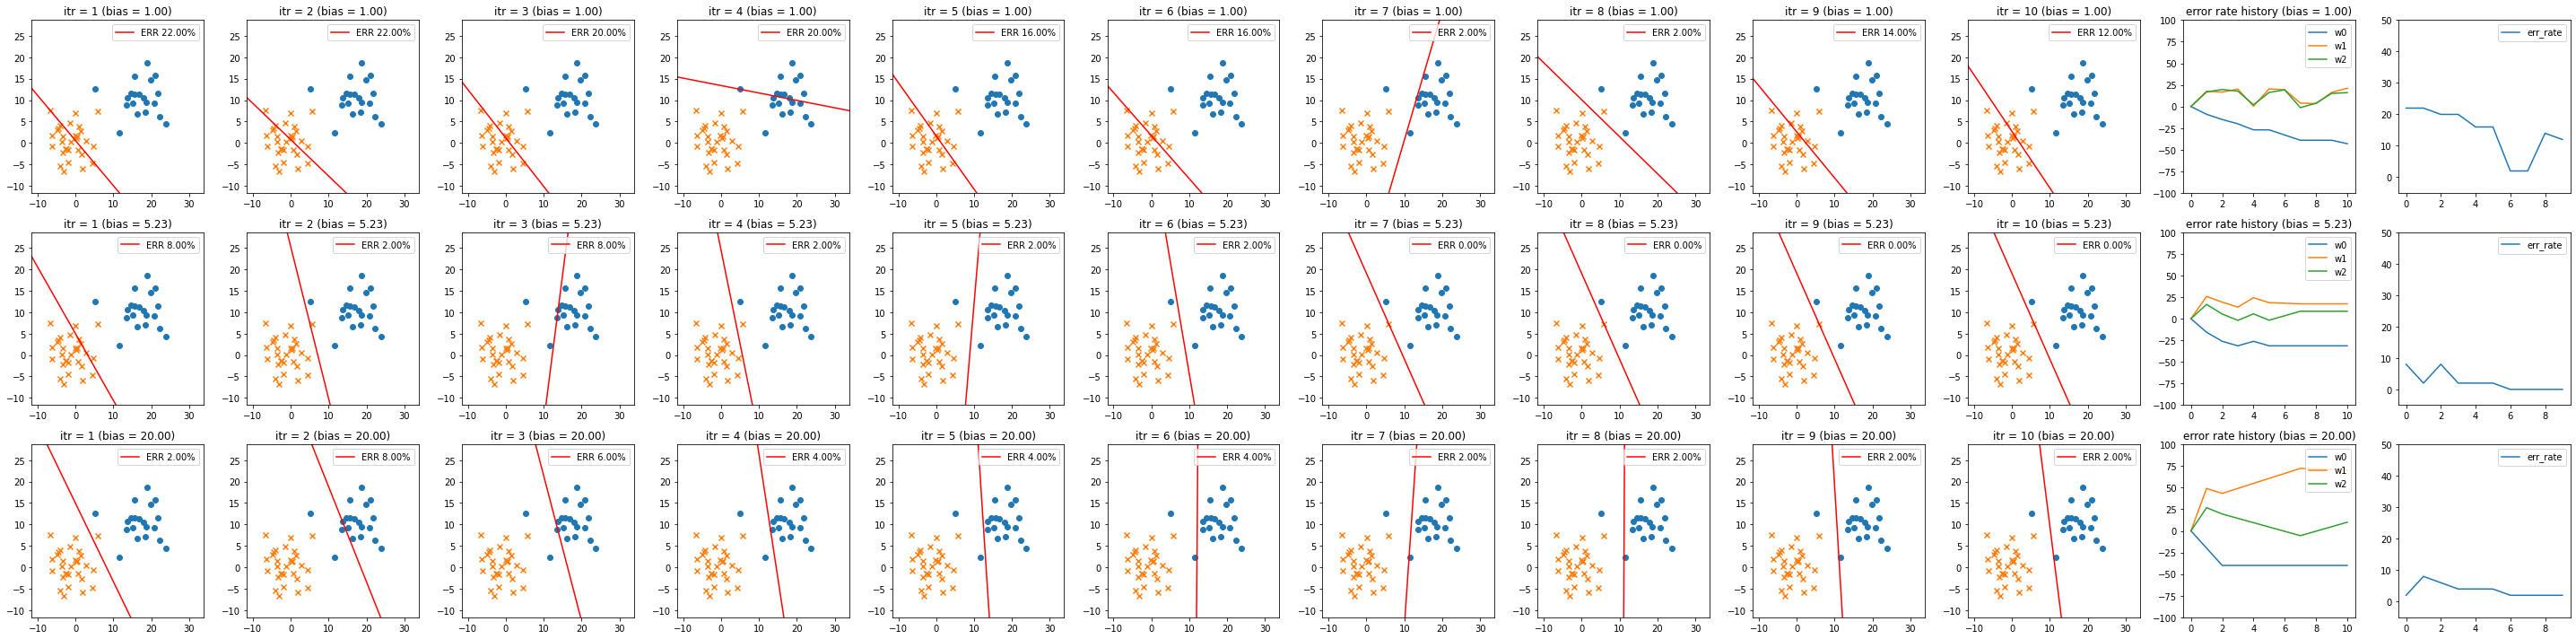

In [13]:
# bias에 따른 결과 변화 시각화
np.random.seed(0)

# 파라미터
max_num_of_iteration = 10
#variance = 30
variance = 15
bias_list = [1, None, 20] # bias가 None인 경우 x_n, y_n의 평균

training_set = create_dataset(variance)

fig, axs = plt.subplots(3, 12, figsize=(40,10))

for row, bias in enumerate(bias_list):       
    for itr in range(max_num_of_iteration): 
        result, w_hist, err_hist, _ = fit_perceptron(training_set, itr+1, bias=bias)
        
        if bias is None:
            _bias = result["bias"]
        else :
            _bias = bias 
        
        plot_data_graph_with_line(training_set, result, axs[row,itr])
        axs[row,itr].set_title("itr = %d (bias = %.2f)" % (itr+1,_bias))

    plot_w_history(w_hist,axs[row][10])
    axs[row][10].set_title("w history (bias = %.2f)" % (_bias))
    plot_error_rate_history(err_hist,axs[row][11])
    axs[row][10].set_title("error rate history (bias = %.2f)" % (_bias))

fig.tight_layout()